In [1]:
'''
This notebook is used to post-process the data obtained from the 
FARGO3D simualations for the Disk-Planet interation and to 
train the DPNNet (Disk Planet Neural Network)

Objective : To train the model to predict planet mass given 
            measured dust gap and other disk parameters 
            
Code : The code is adopted from the Google Tensor Flow platform

This script is the modified version (Flared-Disk version) of the one used in Auddy & Lin 2020 DPNNet paper

ArXiv Link : https://arxiv.org/abs/2007.13779
'''

# Author :Sayantan
# Created : 14 August 2020


from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib as mpl
from sklearn.utils import shuffle

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

import numpy as np
print(tf.__version__)

2.0.0


In [2]:
## Folder to save the filtered data
!mkdir -p data_folder
!mkdir -p figures ## to save the figurs

In [3]:
# ### Data preparation if raw darta is provided otherwise use the next kernel for filtered data directly###

# # dataset_path = '/Volumes/My_Seagate/Training_set/'
# dataset_path = '/Users/sayantan/Desktop/Programming/Dusty_Disk_Gap/Training_set/'
# dataset0 = pd.concat(map(pd.read_csv,glob.glob(dataset_path+'analysis_output_23June_20/*.csv')),ignore_index=True)
# dataset0.to_csv('data_folder/dataset_raw.csv')   # saving the raw data as csv file for future reference

# ## Filtering 1
# dataset0 = dataset0[dataset0['Dust_gap_1']>0.05] ## filtering out very narrow gaps
# dataset =  pd.concat([dataset0], ignore_index=True).sort_index() ## important when merginf multiple datasets
# df = shuffle(dataset)
# dataset = df.reset_index(drop=True)
# dataset['Planet_Mass'] = dataset['Planet_Mass']/(3*10**-6) # writing in unit of earth mass


# ## Filtering 2 removing simualation with more than two gaps
# dataset = dataset[dataset['#_DG'] <= 2] # keeping one and two dust gap disks
# dataset_filtered = dataset.drop(columns=['Sample#']) # dropping the Sample#


# dataset_filtered.to_csv('data_folder/dataset_filered.csv')   # saving the filtered data as csv file for future reference
# dataset = dataset_filtered.drop(columns=['Gas_gap_1','Dust_depth_1','Dust_depth_2','Gas_depth_1','#_DG', '#_GG']) # droping the unimportant columns


# dataset                                 # to take a look at the dataset 

In [4]:
## Import the data directly from the filtered csv file
dataset = pd.read_csv('data_folder/dataset_filered.csv',index_col=0) ## filtered data 
dataset = dataset.drop(columns=['Gas_gap_1','Dust_depth_1','Dust_depth_2','Gas_depth_1','#_DG', '#_GG']) # droping the unimportant columns
dataset

,Planet_Mass,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap_1,Dust_gap_2
0,43.666667,0.0589,0.00174,0.00112,0.0593,0.971,0.345,0.000
1,103.000000,0.0558,0.00467,0.08630,0.0452,0.946,0.845,0.000
2,16.633333,0.0691,0.00989,0.04200,0.0392,0.538,0.074,0.000
3,38.000000,0.0762,0.00694,0.05240,0.0263,1.310,0.718,0.000
4,75.666667,0.0219,0.00151,0.06840,0.0508,1.290,0.878,0.000
...,...,...,...,...,...,...,...,...
783,61.666667,0.0340,0.00156,0.08570,0.0469,1.250,0.857,0.000
784,97.333333,0.0421,0.00348,0.05410,0.0726,1.080,0.681,0.098
785,79.000000,0.0429,0.00830,0.05580,0.0683,1.030,0.103,0.000
786,12.333333,0.0579,0.00354,0.07920,0.0368,0.849,0.677,0.000


In [5]:
## cleaning the data##
dataset.isna().sum()  ## summing the number of na
dataset = dataset.dropna()
dataset

,Planet_Mass,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap_1,Dust_gap_2
0,43.666667,0.0589,0.00174,0.00112,0.0593,0.971,0.345,0.000
1,103.000000,0.0558,0.00467,0.08630,0.0452,0.946,0.845,0.000
2,16.633333,0.0691,0.00989,0.04200,0.0392,0.538,0.074,0.000
3,38.000000,0.0762,0.00694,0.05240,0.0263,1.310,0.718,0.000
4,75.666667,0.0219,0.00151,0.06840,0.0508,1.290,0.878,0.000
...,...,...,...,...,...,...,...,...
783,61.666667,0.0340,0.00156,0.08570,0.0469,1.250,0.857,0.000
784,97.333333,0.0421,0.00348,0.05410,0.0726,1.080,0.681,0.098
785,79.000000,0.0429,0.00830,0.05580,0.0683,1.030,0.103,0.000
786,12.333333,0.0579,0.00354,0.07920,0.0368,0.849,0.677,0.000


In [6]:
# Selecting the training and the test set 
randomState = 0
train_dataset = dataset.sample(frac=0.8,random_state=randomState) ## training with 80 percent of the data
test_dataset = dataset.drop(train_dataset.index)

## save the test-dataset
test_dataset.to_csv('data_folder/test_dataset.csv')
train_dataset.to_csv('data_folder/train_dataset.csv')

train_dataset
# test_dataset

,Planet_Mass,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap_1,Dust_gap_2
383,93.666667,0.0149,0.00517,0.0254,0.0267,0.577,0.796,0.0
489,25.133333,0.0307,0.00288,0.0913,0.0362,0.735,0.751,0.0
352,114.666667,0.0316,0.00522,0.0210,0.0743,0.803,0.689,0.0
14,117.333333,0.0404,0.00181,0.0648,0.0718,0.880,0.935,0.0
146,111.666667,0.0656,0.00344,0.0287,0.0859,1.490,0.103,0.0
...,...,...,...,...,...,...,...,...
25,69.333333,0.0166,0.00842,0.0504,0.0632,0.598,0.111,0.0
110,28.200000,0.0150,0.00285,0.0643,0.0512,0.712,0.710,0.0
150,96.333333,0.0590,0.00940,0.0129,0.0280,0.826,0.726,0.0
153,77.000000,0.0808,0.00103,0.0447,0.0753,1.070,0.800,0.0


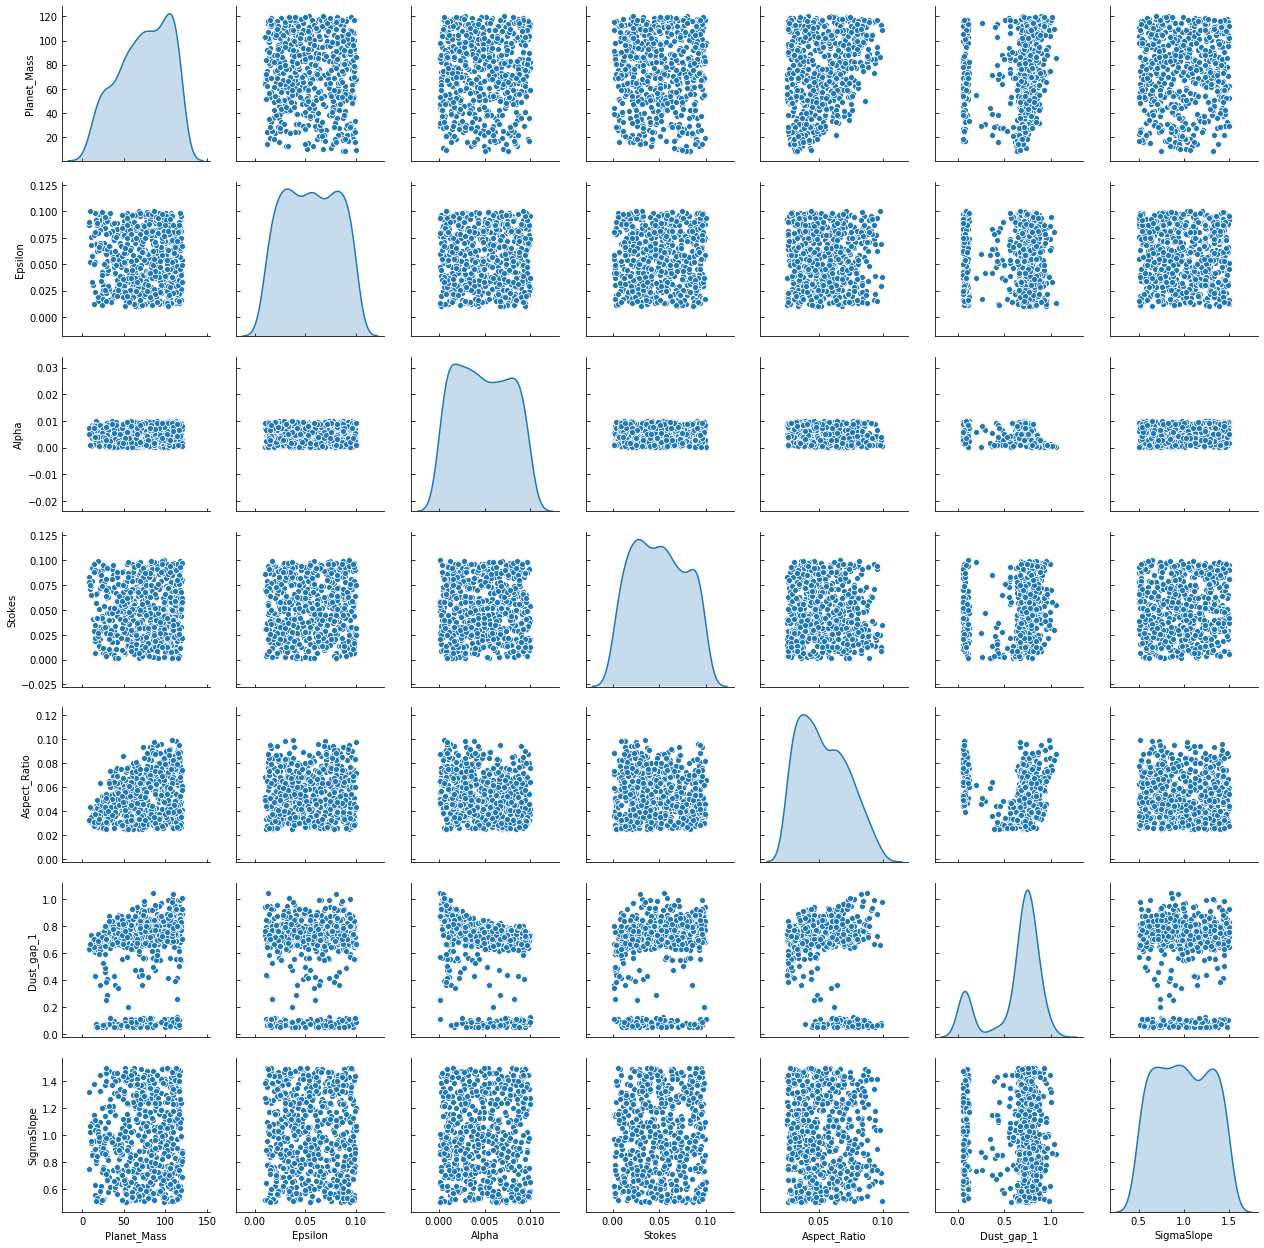

In [7]:
sns.pairplot(train_dataset[["Planet_Mass","Epsilon","Alpha", "Stokes","Aspect_Ratio" ,"Dust_gap_1",'SigmaSlope']], diag_kind="kde")
plt.savefig('figures/relations.pdf')

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("Planet_Mass")
train_stats = train_stats.transpose()

train_stats.to_csv('data_folder/train_stats.csv')
train_stats

,count,mean,std,min,25%,50%,75%,max
Epsilon,626.0,0.055831,0.025991,0.010000,0.032950,0.055450,0.078850,0.10000
Alpha,626.0,0.004860,0.002883,0.000104,0.002345,0.004735,0.007393,0.00999
Stokes,626.0,0.049890,0.027891,0.001120,0.026325,0.049200,0.073075,0.09990
Aspect_Ratio,626.0,0.053632,0.018723,0.025000,0.037825,0.050850,0.068075,0.09940
SigmaSlope,626.0,0.997016,0.296002,0.500000,0.740000,0.991000,1.260000,1.50000
Dust_gap_1,626.0,0.632230,0.270333,0.053000,0.632000,0.726000,0.800000,1.05000
Dust_gap_2,626.0,0.013118,0.068329,0.000000,0.000000,0.000000,0.000000,0.83700


In [9]:
# test_dataset
test_labels = test_dataset.pop("Planet_Mass")

In [10]:
train_labels = train_dataset.pop("Planet_Mass")
print(train_labels)

383     93.666667
489     25.133333
352    114.666667
14     117.333333
146    111.666667
          ...    
25      69.333333
110     28.200000
150     96.333333
153     77.000000
530     81.000000
Name: Planet_Mass, Length: 626, dtype: float64


In [11]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data

,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap_1,Dust_gap_2
383,-1.574820,0.107506,-0.878054,-1.438431,-1.418964,0.605809,-0.191985
489,-0.966908,-0.686796,1.484732,-0.931041,-0.885184,0.439348,-0.191985
352,-0.932280,0.124848,-1.035812,1.103862,-0.655455,0.210000,-0.191985
14,-0.593696,-1.057932,0.534598,0.970338,-0.395322,1.119991,-0.191985
146,0.375886,-0.492556,-0.759736,1.723413,1.665477,-1.957699,-0.191985
...,...,...,...,...,...,...,...
25,-1.509412,1.234789,0.018299,0.511017,-1.348019,-1.928106,-0.191985
110,-1.570973,-0.697201,0.516671,-0.129898,-0.962886,0.287683,-0.191985
150,0.121948,1.574709,-1.326231,-1.368999,-0.577753,0.346869,-0.191985
153,0.960713,-1.328480,-0.186070,1.157272,0.246566,0.620606,-0.191985


## Defining DPNNet architecture

In [12]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation=tf.nn.relu,kernel_regularizer=regularizers.l2(0.0001),input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation=tf.nn.relu,kernel_regularizer=regularizers.l2(0.0001)),
#     layers.Dense(128, activation=tf.nn.relu,kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001) # the optimizer used is RMSprop, one can use SGD(stochastic Gradient decent)
#   optimizer = tf.keras.optimizers.Adam(0.001)

## to study the details see link https://keras.io/optimizers/ ##    

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model



## Model build and Compile

In [13]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 35,073
Trainable params: 35,073
Non-trainable params: 0
_________________________________________________________________


In [14]:
## test the model
example_batch = normed_train_data[:10]
example_batch

,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap_1,Dust_gap_2
383,-1.574820,0.107506,-0.878054,-1.438431,-1.418964,0.605809,-0.191985
489,-0.966908,-0.686796,1.484732,-0.931041,-0.885184,0.439348,-0.191985
352,-0.932280,0.124848,-1.035812,1.103862,-0.655455,0.210000,-0.191985
14,-0.593696,-1.057932,0.534598,0.970338,-0.395322,1.119991,-0.191985
146,0.375886,-0.492556,-0.759736,1.723413,1.665477,-1.957699,-0.191985
423,-0.351301,-0.294848,-0.738223,-0.690698,0.347917,0.591013,-0.191985
758,-1.520954,-0.794321,-1.071667,-0.909677,0.820887,0.742678,-0.191985
254,-1.270864,-1.106492,-1.553187,1.563184,0.314133,0.513330,-0.191985
176,0.075777,-0.263631,1.205070,-0.770812,-0.385187,0.709385,-0.191985
232,-1.717179,0.867121,-1.603383,-0.145921,1.361424,-1.913310,-0.191985


In [15]:
example_result = model.predict(example_batch)
example_result

array([[0.34862912],
       [0.11795815],
       [0.22496754],
       [0.2297087 ],
       [0.33081374],
       [0.12315298],
       [0.27355373],
       [0.3673223 ],
       [0.01432576],
       [0.35218072]], dtype=float32)

In [16]:
##Train the model
## Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 2000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
1995,72.716257,6.062458,72.614540,215.256091,10.677889,215.154388,1995
1996,72.633562,6.034738,72.531830,214.884195,10.663918,214.782425,1996
1997,72.437763,6.009725,72.336014,214.507619,10.626683,214.405823,1997
1998,72.311212,6.078363,72.209412,215.309117,10.710979,215.207352,1998
1999,72.424529,6.045579,72.322731,214.660415,10.654771,214.558594,1999


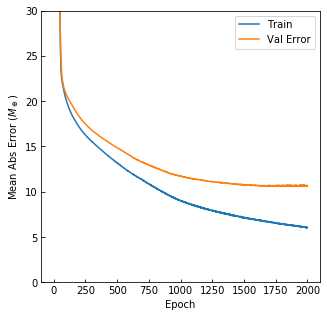

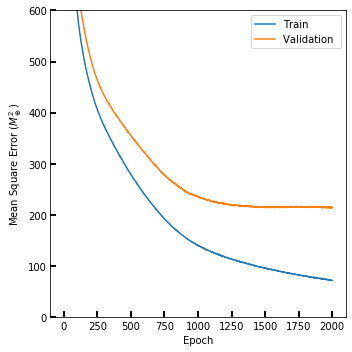

In [18]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(5,5))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ($M_\oplus$)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train ')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()

  plt.figure(figsize=(5,5))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error ($M_\oplus^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Validation ')
  plt.ylim([0,600])
#   plt.xlim([0,700])
#   plt.yscale("log")
  plt.legend()
  plt.tick_params(labelsize=10)
  plt.tick_params(axis='both', which='major',length=6, width=2)
  plt.tick_params(axis='both', which='minor',length=3, width=1.3)  
  plt.tight_layout()
  plt.savefig('figures/validation_loss.pdf',format='pdf',dpi=300)
  plt.show()

  
plot_history(history)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

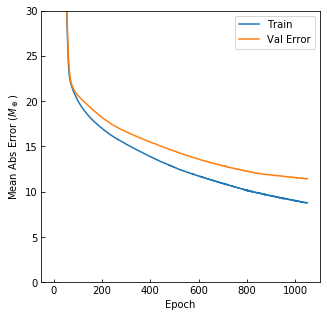

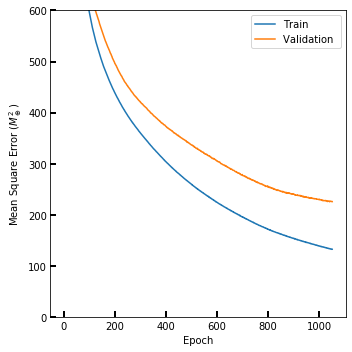

In [19]:
## Using early stopping to prevent over-fitting

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [20]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Square Error: {:5.2f} ".format(mse))
print("Testing set Root Mean Square Error: {:5.2f} M_Earth".format(np.sqrt(mse)))
print("Testing set Mean Abs Error: {:5.2f} M_Earth".format(mae))
print("Testing set Loss : {:5.2f} M_Earth".format(loss))

Testing set Mean Square Error: 185.38 
Testing set Root Mean Square Error: 13.62 M_Earth
Testing set Mean Abs Error:  9.84 M_Earth
Testing set Loss : 185.44 M_Earth


## Saving the network for future use

In [22]:
# Save the entire model as a SavedModel.
# uncomment the following lines if you want to update your model
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [23]:
new_model = tf.keras.models.load_model('saved_model/my_model')
# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 35,073
Trainable params: 35,073
Non-trainable params: 0
_________________________________________________________________


In [24]:
loss, mae, mse = new_model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Square Error: {:5.2f} ".format(mse))
print("Testing set Root Mean Square Error: {:5.2f} M_Earth".format(np.sqrt(mse)))
print("Testing set Mean Abs Error: {:5.2f} M_Earth".format(mae))
print("Testing set Loss : {:5.2f} M_Earth".format(loss))

Testing set Mean Square Error: 185.38 
Testing set Root Mean Square Error: 13.62 M_Earth
Testing set Mean Abs Error:  9.84 M_Earth
Testing set Loss : 185.44 M_Earth


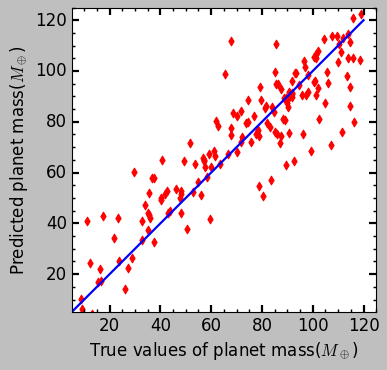

In [25]:
plt.style.use('classic')
plt.figure(figsize = (5,5))
test_predictions = model.predict(normed_test_data).flatten()
plt.scatter(test_labels, test_predictions,s=30,marker='d',color='r')

plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
plt.axis('equal')
plt.axis('square')
plt.xlim(5,125)
plt.ylim(5,125)
# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 120], [0, 120],linewidth=2)

plt.minorticks_on() 
plt.tick_params(labelsize=15)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.tight_layout()
plt.savefig('figures/predicted_correlation.pdf',format='pdf',dpi=300)
# plt.savefig('predicted_correlation.eps',format='eps',dpi=300)


In [26]:
import scipy.stats
scipy.stats.pearsonr(test_labels, test_predictions)

(0.8865219643170213, 9.486233038360446e-54)

SD residual 13.582988741602419
ME 0.9380066088050812


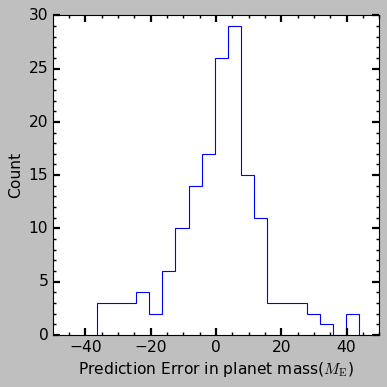

In [27]:
fig = plt.figure(figsize=(5, 5))
error = test_predictions - test_labels
plt.hist(error, bins = 20,facecolor='b', histtype='step', stacked=True,fill=False)
# plt.axis('equal')
# plt.axis('square')
plt.xlim(-50,50)
# plt.ylim(5,125)
plt.xlabel(r"Prediction Error in planet mass($M_{\rm E}$)", Fontsize=14)
_ = plt.ylabel("Count",Fontsize=14)
plt.minorticks_on() 
plt.tick_params(labelsize=14)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.tight_layout()
plt.savefig('figures/error_histogram.pdf',format='pdf',dpi=300)
print("SD residual",np.std(error))
print("ME",np.mean(error))

In [28]:
# THE SD is the mean of the root mean square error (root of MSE)
SD = np.sqrt(mse)

In [29]:
## One test case for the demonstration in the paper
test_index = 110
# print(test_dataset.iloc[[test_index]])
print("Actual Planet Mass is ", test_labels.iloc[[test_index]])
normed_test_data.iloc[[4]]
print("Predicted Planet Mass is " , model.predict(normed_test_data.iloc[[test_index]]))

Actual Planet Mass is  563    100.333333
Name: Planet_Mass, dtype: float64
Predicted Planet Mass is  [[95.81187]]
